In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
print("📊 CODTECH Task 1: Data Pipeline Development")
print("="*60)


📊 CODTECH Task 1: Data Pipeline Development


In [2]:
# Generate sample dataset for demonstration
def generate_sample_data(n_samples=2000):
    np.random.seed(42)
    
    data = {
        'customer_id': range(1, n_samples + 1),
        'age': np.random.randint(18, 80, n_samples),
        'income': np.random.lognormal(10, 0.5, n_samples),
        'credit_score': np.random.randint(300, 850, n_samples),
        'employment_length': np.random.randint(0, 40, n_samples),
        'loan_amount': np.random.lognormal(9, 0.8, n_samples),
        'interest_rate': np.random.uniform(3, 25, n_samples),
        'loan_purpose': np.random.choice(['home', 'auto', 'education', 'business', 'personal'], n_samples),
        'state': np.random.choice(['CA', 'NY', 'TX', 'FL', 'IL'], n_samples),
        'home_ownership': np.random.choice(['rent', 'own', 'mortgage'], n_samples, p=[0.4, 0.3, 0.3]),
        'debt_to_income': np.random.uniform(0, 40, n_samples),
        'loan_status': np.random.choice(['approved', 'rejected'], n_samples, p=[0.7, 0.3])
    }
    
    df = pd.DataFrame(data)
    
    # Introduce missing values
    missing_cols = ['employment_length', 'debt_to_income']
    for col in missing_cols:
        missing_idx = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
        df.loc[missing_idx, col] = np.nan
    
    return df

# Extract data
raw_data = generate_sample_data()
print("✅ Data Extraction Complete")
print(f"📋 Dataset Shape: {raw_data.shape}")
print(f"📊 Dataset Info:")
print(raw_data.info())
raw_data.head()


✅ Data Extraction Complete
📋 Dataset Shape: (2000, 12)
📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        2000 non-null   int64  
 1   age                2000 non-null   int32  
 2   income             2000 non-null   float64
 3   credit_score       2000 non-null   int32  
 4   employment_length  1800 non-null   float64
 5   loan_amount        2000 non-null   float64
 6   interest_rate      2000 non-null   float64
 7   loan_purpose       2000 non-null   object 
 8   state              2000 non-null   object 
 9   home_ownership     2000 non-null   object 
 10  debt_to_income     1800 non-null   float64
 11  loan_status        2000 non-null   object 
dtypes: float64(5), int32(2), int64(1), object(4)
memory usage: 172.0+ KB
None


,customer_id,age,income,credit_score,employment_length,loan_amount,interest_rate,loan_purpose,state,home_ownership,debt_to_income,loan_status
0,1,56,22921.461378,339,37.0,9249.482918,15.250577,business,CA,rent,NaN,approved
1,2,69,36558.098654,517,3.0,2682.182064,23.438459,business,CA,rent,NaN,rejected
2,3,46,7785.289104,381,14.0,5503.317044,11.315304,auto,FL,rent,9.711931,approved
3,4,32,11590.366500,500,23.0,15889.672038,13.200868,home,NY,mortgage,38.903581,rejected
4,5,60,42912.988009,746,24.0,3494.773956,4.947491,auto,NY,mortgage,6.040525,approved


🔍 DATA QUALITY ASSESSMENT
📉 Missing Values:
  employment_length: 200 (10.0%)
  debt_to_income: 200 (10.0%)
🔄 Duplicate Rows: 0
📊 Data Types: {dtype('float64'): 5, dtype('O'): 4, dtype('int32'): 2, dtype('int64'): 1}


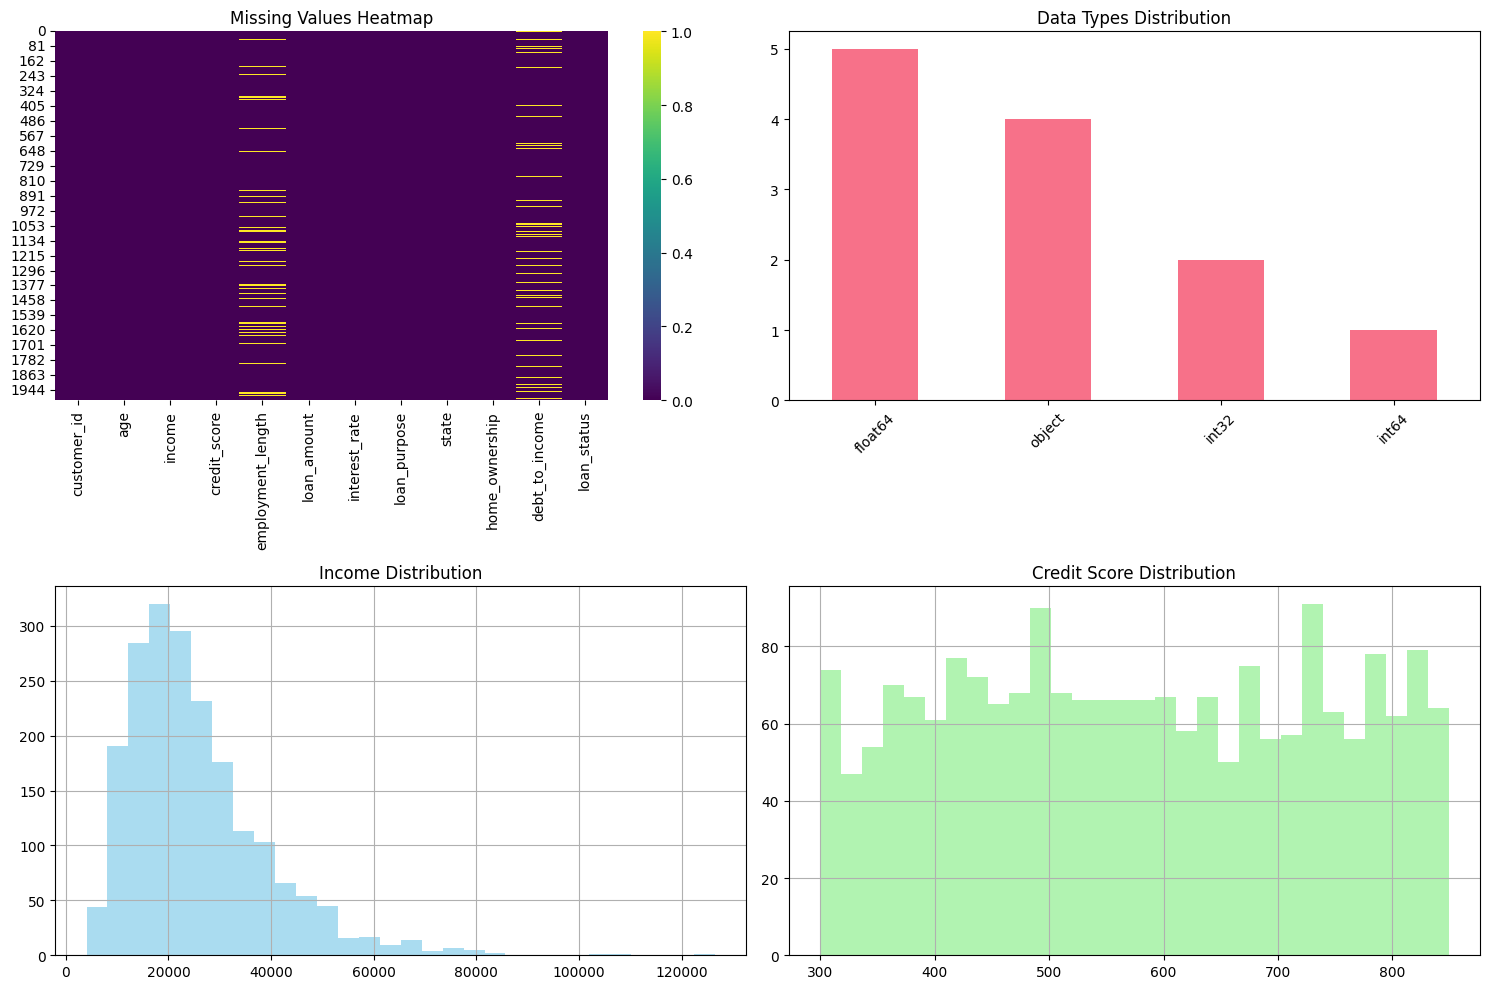

In [3]:
# Data quality assessment
def assess_data_quality(data):
    print("🔍 DATA QUALITY ASSESSMENT")
    print("="*40)
    
    # Missing values
    missing_data = data.isnull().sum()
    if missing_data.any():
        print("📉 Missing Values:")
        for col, count in missing_data[missing_data > 0].items():
            pct = (count / len(data)) * 100
            print(f"  {col}: {count} ({pct:.1f}%)")
    
    # Duplicates
    duplicates = data.duplicated().sum()
    print(f"🔄 Duplicate Rows: {duplicates}")
    
    # Data types
    print(f"📊 Data Types: {data.dtypes.value_counts().to_dict()}")
    
    return missing_data

# Assess quality
missing_stats = assess_data_quality(raw_data)

# Visualize data quality
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Missing values heatmap
sns.heatmap(raw_data.isnull(), cbar=True, ax=axes[0,0], cmap='viridis')
axes[0,0].set_title('Missing Values Heatmap')

# Data types distribution
raw_data.dtypes.value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Data Types Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# Distribution of numeric variables
raw_data['income'].hist(bins=30, ax=axes[1,0], alpha=0.7, color='skyblue')
axes[1,0].set_title('Income Distribution')

raw_data['credit_score'].hist(bins=30, ax=axes[1,1], alpha=0.7, color='lightgreen')
axes[1,1].set_title('Credit Score Distribution')

plt.tight_layout()
plt.show()


In [4]:
# Data transformation functions
def handle_missing_values(data):
    print("🔧 Handling Missing Values...")
    
    # Numeric columns - use KNN imputation
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    for col in numeric_columns:
        if data[col].isnull().any():
            imputer = KNNImputer(n_neighbors=5)
            data[[col]] = imputer.fit_transform(data[[col]])
            print(f"  ✅ Imputed {col} using KNN")
    
    # Categorical columns - use mode
    for col in categorical_columns:
        if data[col].isnull().any():
            mode_val = data[col].mode()[0]
            data[col].fillna(mode_val, inplace=True)
            print(f"  ✅ Filled {col} with mode: {mode_val}")
    
    return data

def feature_engineering(data):
    print("⚙️ Engineering New Features...")
    
    # Create ratio features
    data['loan_to_income_ratio'] = data['loan_amount'] / (data['income'] + 1)
    data['credit_utilization'] = data['debt_to_income'] / 100
    
    # Age groups
    data['age_group'] = pd.cut(data['age'], 
                              bins=[0, 25, 35, 50, 65, 100], 
                              labels=['young', 'adult', 'middle_age', 'senior', 'elderly'])
    
    # Credit score categories
    data['credit_grade'] = pd.cut(data['credit_score'],
                                 bins=[0, 580, 670, 740, 800, 850],
                                 labels=['poor', 'fair', 'good', 'very_good', 'excellent'])
    
    print(f"  ✅ Created 4 new features")
    return data

def encode_categorical_variables(data, target_col):
    print("🏷️ Encoding Categorical Variables...")
    
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]
    
    encoded_data = data.copy()
    
    for col in categorical_cols:
        unique_vals = data[col].nunique()
        
        if unique_vals <= 5:  # One-hot encode
            dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
            encoded_data = pd.concat([encoded_data, dummies], axis=1)
            encoded_data.drop(col, axis=1, inplace=True)
            print(f"  ✅ One-hot encoded {col} ({unique_vals} categories)")
        else:  # Label encode
            le = LabelEncoder()
            encoded_data[col] = le.fit_transform(data[col])
            print(f"  ✅ Label encoded {col} ({unique_vals} categories)")
    
    return encoded_data

# Apply transformations
print("🔄 TRANSFORMATION PHASE")
print("="*30)

# Handle missing values
clean_data = handle_missing_values(raw_data.copy())

# Feature engineering
enhanced_data = feature_engineering(clean_data)

# Encode categorical variables
processed_data = encode_categorical_variables(enhanced_data, 'loan_status')

print(f"\n📊 Transformation Summary:")
print(f"Original shape: {raw_data.shape}")
print(f"Processed shape: {processed_data.shape}")
print(f"New features added: {processed_data.shape[1] - raw_data.shape[1]}")


🔄 TRANSFORMATION PHASE
🔧 Handling Missing Values...
  ✅ Imputed employment_length using KNN
  ✅ Imputed debt_to_income using KNN
⚙️ Engineering New Features...
  ✅ Created 4 new features
🏷️ Encoding Categorical Variables...
  ✅ One-hot encoded loan_purpose (5 categories)
  ✅ One-hot encoded state (5 categories)
  ✅ One-hot encoded home_ownership (3 categories)
  ✅ One-hot encoded age_group (5 categories)
  ✅ One-hot encoded credit_grade (5 categories)

📊 Transformation Summary:
Original shape: (2000, 12)
Processed shape: (2000, 29)
New features added: 17


In [5]:
# Feature scaling and selection
def scale_features(data, target_col):
    print("📏 Scaling Features...")
    
    # Separate features and target
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), 
                           columns=X.columns, 
                           index=X.index)
    
    print(f"  ✅ Scaled {X.shape[1]} features using StandardScaler")
    
    return X_scaled, y, scaler

def select_best_features(X, y, k=15):
    print(f"🎯 Selecting Best {k} Features...")
    
    # Encode target if needed
    if y.dtype == 'object':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
    else:
        y_encoded = y
    
    # Select best features
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y_encoded)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"  ✅ Selected features: {selected_features[:5]}... (showing first 5)")
    
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

# Apply scaling and selection
X_scaled, y, scaler = scale_features(processed_data, 'loan_status')
X_final, selected_features = select_best_features(X_scaled, y, k=15)

print(f"\n📈 Feature Engineering Complete:")
print(f"Final feature count: {X_final.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")


📏 Scaling Features...
  ✅ Scaled 28 features using StandardScaler
🎯 Selecting Best 15 Features...
  ✅ Selected features: ['credit_score', 'employment_length', 'debt_to_income', 'credit_utilization', 'loan_purpose_business']... (showing first 5)

📈 Feature Engineering Complete:
Final feature count: 15
Target distribution: {'approved': 1405, 'rejected': 595}


In [6]:
# Data loading and splitting
def create_train_test_split(X, y, test_size=0.2, random_state=42):
    print("🚂 Creating Train/Test Split...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"  📊 Training set: {X_train.shape[0]} samples")
    print(f"  📊 Testing set: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

def save_processed_data(X_train, X_test, y_train, y_test):
    print("💾 Saving Processed Data...")
    
    # Save to CSV files
    X_train.to_csv('X_train.csv', index=False)
    X_test.to_csv('X_test.csv', index=False)
    y_train.to_csv('y_train.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)
    
    # Save full processed dataset
    full_processed = pd.concat([X_final, y], axis=1)
    full_processed.to_csv('processed_loan_data.csv', index=False)
    
    print("  ✅ Saved X_train.csv, X_test.csv, y_train.csv, y_test.csv")
    print("  ✅ Saved processed_loan_data.csv")
    
    return ['X_train.csv', 'X_test.csv', 'y_train.csv', 'y_test.csv', 'processed_loan_data.csv']

# Create splits and save data
X_train, X_test, y_train, y_test = create_train_test_split(X_final, y)
saved_files = save_processed_data(X_train, X_test, y_train, y_test)

# Pipeline summary
print("\n🎉 ETL PIPELINE COMPLETED SUCCESSFULLY!")
print("="*50)
print("📋 Pipeline Summary:")
print(f"  • Original dataset: {raw_data.shape}")
print(f"  • Missing values handled: {missing_stats[missing_stats > 0].sum()}")
print(f"  • Features engineered: 4 new features")
print(f"  • Final processed shape: {X_final.shape}")
print(f"  • Files saved: {len(saved_files)}")
print(f"  • Train/test split: {len(X_train)}/{len(X_test)}")


🚂 Creating Train/Test Split...
  📊 Training set: 1600 samples
  📊 Testing set: 400 samples
💾 Saving Processed Data...
  ✅ Saved X_train.csv, X_test.csv, y_train.csv, y_test.csv
  ✅ Saved processed_loan_data.csv

🎉 ETL PIPELINE COMPLETED SUCCESSFULLY!
📋 Pipeline Summary:
  • Original dataset: (2000, 12)
  • Missing values handled: 400
  • Features engineered: 4 new features
  • Final processed shape: (2000, 15)
  • Files saved: 5
  • Train/test split: 1600/400
